## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np


### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [4]:
#!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

#with open('onegin.txt', 'r') as iofile:
    #text = iofile.readlines()

#text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(text))
tokens.append('<') # <SOS>

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here
idx_to_token = {index: char for index, char in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
token_to_idx = {char: index for index, char in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
text_encoded = [token_to_idx[x] for x in text]

In [9]:
num_tokens = len(tokens)

In [10]:
seq_length = 100
start_token = token_to_idx["<"]

def generate_chunk():
    global text_encoded, start_token, seq_length

    # Генерация случайного начального индекса
    start_index = np.random.randint(0, len(text_encoded) - seq_length - 1)

    # Извлечение последовательности данных
    data = np.array(text_encoded[start_index : start_index + seq_length])

    # Добавление стартового токена в начало последовательности
    yield np.concatenate(([start_token], data))


In [11]:
def random_training_set():
    # Генерация случайного фрагмента данных, преобразование его в тензор и упаковка в Variable
    chunk = Variable(torch.Tensor(next(generate_chunk()))).type(torch.LongTensor)

    inp = chunk[:-1].to(device)  # Входные данные, отбрасываем последний элемент
    target = chunk[1:].to(device)  # Целевые данные, отбрасываем первый элемент

    return inp, target

In [12]:
# Your code here

# Определение класса RNN, наследующего от nn.Module
class RNN(nn.Module):
    # Инициализация модели
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()  # Вызов конструктора родительского класса nn.Module
        self.input_size = input_size  # Размерность входных данных
        self.hidden_size = hidden_size  # Размерность скрытого состояния
        self.output_size = output_size  # Размерность выходных данных
        self.n_layers = n_layers  # Количество слоев в RNN

        # Слой для кодирования входных данных с помощью эмбеддингов
        self.encoder = nn.Embedding(input_size, hidden_size)
        # RNN слой, принимающий скрытое состояние и генерирующий новое скрытое состояние
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        # Линейный слой для преобразования скрытого состояния в выходное значение
        self.decoder = nn.Linear(hidden_size, output_size)

    # Прямой проход через модель
    def forward(self, input, hidden):
        # Преобразование входных данных через эмбеддинг
        input = self.encoder(input.view(1, -1))
        # Пропуск через RNN, где output - это результат, а hidden - новое скрытое состояние
        output, hidden = self.rnn(input.view(1, 1, -1), hidden)
        # Преобразование выходных данных с помощью линейного слоя
        output = self.decoder(output.view(1, -1))
        return output, hidden

    # Инициализация скрытого состояния
    def init_hidden(self):
        # Возвращает скрытое состояние, состоящее из нулей
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))


In [13]:
def train(inp, target):
    # Инициализация скрытого состояния на первом шаге
    hidden = decoder.init_hidden()
    # Обнуление градиентов параметров модели перед новым проходом
    decoder.zero_grad()
    # Инициализация переменной для накопления ошибки
    loss = 0

    # Цикл по каждому символу во входной последовательности
    for c in range(seq_length):
        # Пропуск входа через декодер (RNN) для получения выхода и обновления скрытого состояния
        output, hidden = decoder(inp[c], hidden)
        # Накопление ошибки по каждой временной точке
        loss += criterion(output, target[c].unsqueeze(0))

    # Вычисление градиентов по всей ошибке
    loss.backward()
    # Обновление параметров модели с помощью оптимизатора
    decoder_optimizer.step()

    # Возвращаем среднее значение ошибки на одном примере (нормированное по длине последовательности)
    return loss.data.item() / seq_length


In [14]:
import time, math

def time_since(since): # Вычисление времени, прошедшего с момента начала (since)
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [15]:
def generate_sample(
    char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device
):
    """
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    """
    # Если задан seed_phrase, преобразуем его в последовательность индексов, добавив <SOS>-токен "<"
    if seed_phrase is not None:
        x_sequence = [token_to_idx["<"]] + [
            token_to_idx[token] for token in seed_phrase
        ]
    else:         # Если seed_phrase не задан, начинаем с <SOS>-токена
        x_sequence = [token_to_idx["<"]]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    # Инициализация скрытого состояния
    hidden = char_rnn.init_hidden()
    # Пропускаем seed_phrase через RNN, чтобы задать начальное скрытое состояние
    for i in range(len(x_sequence[0]) - 1):
        input_tensor = x_sequence[0][i].unsqueeze(0).unsqueeze(0)  # Reshape to (1, 1)
        output, hidden = char_rnn(input_tensor, hidden)

    # Генерация символов для продолжения текста
    for _ in range(max_length - len(x_sequence[0]) + 1):
        input_tensor = x_sequence[0][-1].unsqueeze(0).unsqueeze(0)  # Last character
        output, hidden = char_rnn(input_tensor, hidden)

        # Применение температурного масштабирования к выходу для управления случайностью
        output_dist = torch.softmax(output / temperature, dim=1).data
        top_idx = torch.multinomial(output_dist, num_samples=1).item()

        # Добавляем выбранный символ в последовательность
        x_sequence = torch.cat([x_sequence, torch.tensor([[top_idx]], dtype=torch.int64).to(device)], dim=1)

    # Преобразуем полученную последовательность индексов обратно в строку и убираем <SOS>-токен
    return "".join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]]).replace('<', '')

In [16]:
n_epochs = 2000  # Общее количество эпох для тренировки
hidden_size = 100  # Размер скрытого слоя в сети
print_every = 100  # Частота вывода результатов (каждые 100 эпох)
plot_every = 10   # Частота сохранения средней ошибки для построения графика
n_layers = 1  # Количество слоев в RNN
lr = 0.005  # Скорость обучения

decoder = RNN(num_tokens, hidden_size, num_tokens, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    # Получаем случайный набор данных для тренировки
    inp, target = random_training_set()
    # Выполняем один шаг обучения
    loss = train(inp, target)
    # Накопление среднего значения потерь
    loss_avg += loss

    # Печать результатов каждые 'print_every' эпох
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        # Генерация примера текста с использованием текущей модели
        print(generate_sample(decoder, seed_phrase='hello', max_length=100, temperature=0.8, device=device), '\n')

    # Сохранение потерь для графика каждые 'plot_every' эпох
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0  # Обновление накопленных потерь


 2s (100 5%) 2.0213]
hellove coun art bin st pavand buau
    no and eraint thin ely his iy and bivs be and ate lound in h 

 5s (200 10%) 1.9153]
hellous'd ngatt,
  what muief?
   ands 'ints the hound?
  xxplamt the samand heast,
  no yame,
  thi 

 7s (300 15%) 2.4290]
hello i jovn thake.
   ill om stall wine owntst kele eoth with lowe though swith to sumt that that r 

 10s (400 20%) 2.1245]
hellongurge no gothy thourcong?
  me not fich sprres in dere inch her wif which end me,
      in,
   

 12s (500 25%) 1.8347]
hellovn art chappiong and geaster mor at no chill's tould a fairy thy loves y, wre's my a true wild  

 15s (600 30%) 1.8187]
hellonk, duts the in mo me thy this'd the me the dids deter mose of thost vay,
  though nelly werse  

 17s (700 35%) 2.2088]
hellong thy seess for wayst thou his the soos dost,
  frue ous beous the reed;
  hall oun art one, n 

 20s (800 40%) 1.6955]
hellone is love being prost is ple in son there all know woul not your sins on gravore can your lov

Plot the loss function (axis X: number of epochs, axis Y: loss function).

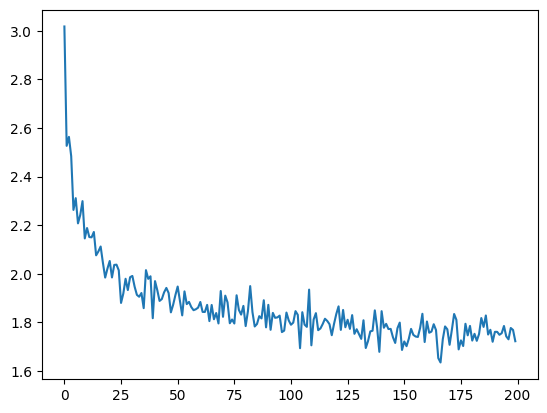

In [17]:
# Your plot code here
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [18]:
# An example of generated text.
print(generate_sample(char_rnn=decoder, max_length=500, temperature=0.2))

 i in the own dead had shape the reath the in the show the own diss show shall of the in the shad the in diss love i am in the rest in the conquess of the the shall of the in the shall in the shad of the reast i the shape own diss the is the own the rest the i in the reature of the reast i in this the on the i in the such the of the shappess of the own diss of the in the shad of the shall of the own the rest shape in the red of the surself be the in diss of the rest,
  but i in the show shall of


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

**Answer:** the final loss became slightly better.

In [19]:
# Your beautiful code here
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTM, self).__init__()
        self.input_size = input_size  # Размер входа (число уникальных токенов)
        self.hidden_size = hidden_size  # Размер скрытого слоя (вектор состояния)
        self.output_size = output_size  # Размер выходного слоя (число токенов на выходе)
        self.n_layers = n_layers  # Количество слоев в LSTM

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # Преобразуем вход в вектор скрытого состояния с помощью Embedding
        input = self.encoder(input.view(1, -1))  # Преобразуем вектор индексов в embedding
        # Пропускаем через LSTM слой
        output, hidden = self.lstm(input.view(1, 1, -1), hidden)
        # Преобразуем выход LSTM в результат с помощью линейного слоя
        output = self.decoder(output.view(1, -1))
        return output, hidden  # Возвращаем выход и обновленное скрытое состояние

    def init_hidden(self):
        # Состояние скрытых слоев LSTM состоит из двух частей: hidden_state (скрытое состояние) и cell_state (состояние ячейки)
        return (Variable(torch.zeros(self.n_layers, 1, self.hidden_size)),
                Variable(torch.zeros(self.n_layers, 1, self.hidden_size)))


In [20]:
def train_lstm(inp, target):
    hidden = lstm_model.init_hidden()
    lstm_model.zero_grad()
    loss = 0

    # Проходим по каждому символу в последовательности
    for c in range(seq_length):
        output, hidden = lstm_model(inp[c].unsqueeze(0), hidden)  # добавляем размерности с помощью unsqueeze(0) для подачи в LSTM

        # Вычисление потерь для текущего шага
        loss += criterion(output, target[c].unsqueeze(0))  # добавляем размерности с помощью unsqueeze(0) для подачи в LSTM

    # Обратное распространение ошибки через сеть
    loss.backward()
    # Шаг оптимизации для обновления параметров модели
    optimizer.step()

    # Возвращаем среднее значение потерь для текущей последовательности
    return loss.item() / seq_length  # Делим на длину последовательности для усреднения


 12s (100 5%) 2.1841]
hellof dien wiik ih fo mat wide
  the
  the yhone deed

  hee is thou shat ith an hien, no hat hat l 

 25s (200 10%) 1.9827]
hellont wh and prii

  xxxvet thy wor sht in the sp in ah the my ruys?
  thou in sur ekire me,
  nor 

 37s (300 15%) 2.0495]
hellost tellos in thoughth chase dot thy woroo mays for that thou ball my prest thout your let cathr 

 49s (400 20%) 1.7545]
hellour to and to love and untioghthe prantonds how,
   for wichou by and my some roth my at of thy  

 0s (500 25%) 1.8820]
hellone.
  then will have how,
  and the hy beart have worrs, thy would's be is lindes then state,
  

 12s (600 30%) 1.9212]
hellones eveeck,
  and a'd of come thiny my gride ming but in me seet and soore thiny streater may v 

 24s (700 35%) 1.6335]
helloy, for other poth bartinst shaln not fatcht, wrickent sull tingue;
  and ?ond, haty my day on t 

 36s (800 40%) 1.8313]
hello, the should i his bow;
  comen thee then shall beath you bother my newers, and thee eases t

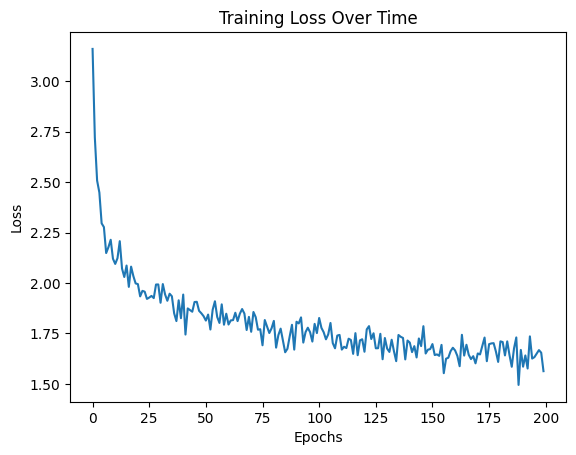

In [21]:
lstm_model = LSTM(num_tokens, hidden_size, num_tokens).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

n_epochs = 2000 # Задание числа эпох для обучения
print_every = 100  # Выводить информацию о потере каждые 100 эпох
plot_every = 10  # Каждый 10-й выводить усреднённые потери для графика
all_losses = []  # Список для хранения потерь на каждой эпохе
loss_avg = 0  # Переменная для усреднения потерь на интервале

start = time.time()  # Начало отсчёта времени тренировки

# Цикл по эпохам тренировки
for epoch in range(1, n_epochs + 1):
    inp, target = random_training_set()  # Получаем случайную обучающую выборку
    loss = train_lstm(inp, target)  # Обучение на текущем батче
    loss_avg += loss  # Накопление потерь

    # Вывод потерь и сгенерированного текста каждые 'print_every' эпох
    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate_sample(lstm_model, seed_phrase='hello', max_length=100, temperature=0.8), '\n')

    # Добавление усреднённых потерь каждые 'plot_every' эпох
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0  # Сбрасываем накопленные потери для следующего интервала

plt.figure()
plt.plot(all_losses)  # Отображение всех усреднённых потерь
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [22]:
# Text generation with different temperature values here
for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f'Temperature {temperature}: \n', generate_sample(lstm_model, max_length=500, temperature=temperature))

Temperature 0.1: 
  the strong she shall the strong the strong the prich more shall the strange strong the strong show show show show shall the strong the strong the strong shall the strong the stay,
  and shall the strong the strong shall the shall the strong the strong the streast the strong show the strong shall the strong the strange the strong she strong shall the strong the strong shall show show in me shall the strong the strong shall the shall the shall the strong strong the strong show the strong strown s
Temperature 0.2: 
  the strong shall the strange in the praise the strong she summer the still shall in the prove the shall the see the fair the price stay,
  and the summer and the summer me shall the shall the shall the strong the strange still the should the strong strong see the prich should the strange shall summer should the string shall the should should the stay should the strange the strong the still the stall the see shall the shall in the stall the summer in me see

Interpretation: at low temperatures generated texts are highly repetitive, at medium temperatures the texts are more diverse yet still coherent, and at the highest temperature the text become meaningless and incomprehensible.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [23]:
# Saving and loading code here
model_path = "lstm_text_generator.pth"
torch.save(lstm_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to lstm_text_generator.pth


In [24]:
loaded_model = LSTM(num_tokens, hidden_size, num_tokens)

loaded_model.load_state_dict(torch.load(model_path))

loaded_model.to(device)

loaded_model.eval()
print("Model loaded successfully!")


Model loaded successfully!


C:\Users\Warain\AppData\Local\Temp\ipykernel_21932\3839505532.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))


In [25]:
seed_phrase = "hello"
generated_text = generate_sample(
    char_rnn=loaded_model,
    seed_phrase=seed_phrase,
    max_length=100,
    temperature=1.0
)

print("Generated text:", generated_text)


Generated text: helloly love,
  and,
    or i deakelling way,
  and not and doth oftronger mort suctent'st conce,
  


In [26]:
model_path2 = "vanilla_rnn_text_generator.pth"
torch.save(decoder.state_dict(), model_path2)
print(f"Model saved to {model_path2}")

Model saved to vanilla_rnn_text_generator.pth


In [27]:
loaded_model2 = RNN(num_tokens, hidden_size, num_tokens, n_layers)

loaded_model2.load_state_dict(torch.load(model_path2))

loaded_model2.to(device)

loaded_model2.eval()
print("Model loaded successfully!")

Model loaded successfully!


C:\Users\Warain\AppData\Local\Temp\ipykernel_21932\3531106751.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model2.load_state_dict(torch.load(model_path2))


In [28]:
generated_text = generate_sample(
    char_rnn=loaded_model2,
    seed_phrase=seed_phrase,
    max_length=100,
    temperature=1.0
)

print("Generated text:", generated_text)


Generated text: hellokturs your all renture's lird,
  but disse idsthins tcue ithrid moith the of prilse adger,
    


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)